In [2]:
!ls data

'ls' is not recognized as an internal or external command,
operable program or batch file.


# Chapter 6 Linear Model Selection and Regularization
Linear models still can do astonishingly well compared to non-linear models. This chapter will explore other types of fitting besides least squares because they can give better prediction accuracy and interpretability.

## Classes of alternatives to least squares
* Subset Selection - Choose a subset of the predictors
* Shrinkage (regularization) - Fit all predictors but limit their size. Coefficients can go to 0.
* Dimension Reduction - project the predictors into a smaller subspace

## Best Subset Selection
Fit all possible models $2^p$ and take the best model using cross-validated
prediction error, Cp, AIC, BIC, or adjusted $R^2$. This can be impossible with large enough p

## Stepwise Selection - Forward, Backward and both
Because of computational limitation a simpler method of adding or subtracting the best predictor to the current model is employed.

### Forward Selection
Start with an empty model and choose on predictor to add to the model based on best adjusted $R^2$ or other similar metric. Continue adding variables until no improvement in adjusted $R^2$. 

A variation to this is to retain each model at each step and use $R^2$ (not adjusted) as the metric. This will build p models. Then use cross validation with $R^2$ to pick the best model of those p models built from forward selection.

### Backward Selection
Similar to forward selection but start with all predictors in model and remove one at a time until adjusted $R^2$ is maximized or alternatively, find p models with $R^2$ and then use cross validation to pick best of the p models.

## Both
At each step, consider both adding or subtracting a variable in the model.

#### Example: Best subset
Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year. 

$y = \beta_0$ find the $R_{adj}=0.2$. 


$y = \beta_0 + \beta_1 x_1$ $R_{adj}=0.2$

$y = \beta_0 + \beta_1 x_2$ $R_{adj}=0.4$

$y = \beta_0 + \beta_1 x_2 + \beta_2 x_1$ $R_{adj}=0.4$

$y = \beta_0 + \beta_1 x_2 + \beta_2 x_3$ $R_{adj}=0.6$

$\vdots$

$y = \beta_0 + \beta_1 x_2 + \beta_2 x_3 + \beta_3 x_5$ $R_{adj}=0.8$

### backward
$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_5 x_5$ $R_{adj}=0.8$

$y = \beta_0 +  \beta_2 x_2 + \cdots + \beta_5 x_5$ $R_{adj}=0.85$




## F/B selection
$y = \beta_0 $ $R_{adj}=0.2$

$\vdots$

$y = \beta_0 + \beta_1 x_2 + \beta_2 x_3 + \beta_3 x_5$ $R_{adj}=0.8$

$\vdots$

$y = \beta_0 + \beta_1 x_2 + \beta_3 x_5$ $R_{adj}=0.85$

In [ ]:
2**10

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [4]:
hitters_df = pd.read_csv('data/hitters.csv')
hitters_df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,#NAME?,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,#NAME?,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,#NAME?,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,#NAME?,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,#NAME?,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the `Salary` variable is missing for some of the
players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` value
for any elements that are missing, and a `FALSE` value for non-missing elements.
The `sum()` function can then be used to count all of the missing elements:

In [ ]:
print("Number of null values:", hitters_df["Salary"].isnull().sum())

In [ ]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_df.shape)

# Drop any rows the contain missing values, along with the player names
hitters_df_clean = hitters_df.dropna().drop('Unnamed: 0', axis=1)

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_df_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_df_clean["Salary"].isnull().sum())

In [ ]:
dummies = pd.get_dummies(hitters_df_clean[['League', 'Division', 'NewLeague']])

y = hitters_df_clean.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_df_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

We can perform best subset selection by identifying the best model that contains a given number of predictors, where **best** is quantified using RSS. We'll define a helper function to outputs the best set of variables for
each model size:

In [ ]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)].astype(float))
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [ ]:
def getBest(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [ ]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Now we have one big DataFrame that contains the best models we've generated along with their RSS:

In [ ]:
models_best

If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [ ]:
print(models_best.loc[7, "model"].summary())

This output indicates that the best two-variable model contains only Hits and CRBI. To save time, we only generated results up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [ ]:
# Show the best 19-variable model (there's actually only one)
print(getBest(17)["model"].summary())

Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For example, if we want the $R^2$ value:

In [ ]:
models_best.loc[2, "model"].rsquared

In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [ ]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[1].rsquared, axis=1)

As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the `type="l"` option tells `R` to
connect the plotted points with lines:

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

In [ ]:
rsquared_adj.argmax()

In [ ]:
rsquared_adj.max()

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

#### Example: Forward Selection

In [ ]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

In [ ]:
print(models_fwd.loc[1, "model"].summary())
print(models_fwd.loc[2, "model"].summary())

We see that using forward stepwise selection, the best one-variable
model contains only `Hits`, and the best two-variable model additionally
includes `CRBI`. Let's see how the models stack up against best subset selection:

In [ ]:
print(models_best.loc[6, "model"].summary())
print(models_fwd.loc[6, "model"].summary())

#### Example: Backward Selection

In [ ]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time", (toc-tic), "seconds.")

In [ ]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)

In [ ]:
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)

In [ ]:
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

# Choosing Optimal Model 
## Adjusting Training Statistics or Using Cross Validation
As learned in Chapter 5, cross validation is an extremely good tool at giving us insight to how well the model will be used on unseen data (test data).

But alternatively to cross validation, we can punish the training error statistics so in theory they can give us insight on what the test error will be. There have been several statistics developed to give us insight as to what the model will do for unseen errors.

The 4 most popular are AIC, BIC, Mallows Cp and Adjusted R^2. AIC, BIC and Cp all have similar formulas that inflate the error for more predictors and a higher estimated variance. Adjusted R squared lowers the R^2 by each additional predictor in the model. All 4 of these statistics are 'classical' model selectors and were commonly used.

Cross validation can be computationally intense but with modern computation we can build lots of models and evaluate them easily.

#### Example: Model selection using the Validation Set Approach

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('data/hitters.csv')

# Drop any rows the contain missing values, along with the player names
df = df.dropna().drop('Unnamed: 0', axis=1)

# Get dummy variables
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

# Extract independent variable
y = pd.DataFrame(df.Salary)

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)

In [ ]:
df.head()

+ In order for the validation set approach to yield accurate estimates of the test error, we must use only the training observations to perform all aspects of model-fitting — including variable selection. 
+ Therefore, the determination of which model of a given size is best must be made using only the training observations. 
+ This point is subtle but important. If the full data set is used to perform the best subset selection step, the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

+ In order to use the validation set approach, we begin by splitting the observations into a training set and a test set. 
+ We do this by creating a random vector, train, of elements equal to TRUE if the corresponding observation is in the training set, and FALSE otherwise. 
+ The vector test is TRUE if the observation is in the test set, and a FALSE otherwise. 
+ Note the np.invert() in the command to create test causes TRUEs to be switched to FALSEs and vice versa.
+ We also set a random seed so that the user will obtain the same training set/test set split.

In [ ]:
np.random.seed(seed=12)
train = np.random.choice([True, False], size = len(y), replace = True)
test = np.invert(train)

In [ ]:
test.shape

+ We'll define our helper function to outputs the best set of variables for each model size like we did previously. 
+ Note that we'll need to modify this to take in both test and training sets, because we want the returned error to be the test error:

In [ ]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)].astype(float))
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

And our function to perform forward selection:

In [ ]:
def forward(predictors, X_train, y_train, X_test, y_test):
    
    results = []

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
        
    # Return the best model, along with some other useful information about the model
    return best_model

Now, we'll call our `forward()` function on the training set in order to perform forward selection for all model sizes:

In [ ]:
models_train = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,len(X.columns)+1):    
    models_train.loc[i] = forward(predictors, X[train], y[train]["Salary"], X[test], y[test]["Salary"])
    predictors = models_train.loc[i]["model"].model.exog_names

Now let's plot the errors, and find the model that minimizes it:

In [ ]:
plt.plot(models_train["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(pd.to_numeric(models_train["RSS"]).argmin()+1, models_train["RSS"].min(), "or")

+ We find that the best model (according to the validation set approach) is the one that contains 10 predictors.

+ Now that we know what we're looking for, let's perform best subset selection on the full dataset and select the best 10-predictor model. 
+ It is important that we make use of the *full data set* in order to obtain more accurate coefficient estimates. 
+ We perform this selection on the *full data set* and select the best 10-predictor model, rather than simply using the predictors that we obtained from the training set, because the best 10-predictor model on the full data set may differ from the corresponding model on the training set.

In [ ]:
models_test = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,11):    
    models_test.loc[i] = forward(predictors, X[test], y[test]["Salary"], X[test], y[test]["Salary"])
    predictors = models_test.loc[i]["model"].model.exog_names

In [ ]:
models_trainonly = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,11):    
    models_trainonly.loc[i] = forward(predictors, X[train], y[train]["Salary"], X[train], y[train]["Salary"])
    predictors = models_train.loc[i]["model"].model.exog_names

In fact, we see that the best ten-variable model on the full data set has a different set of predictors than the best ten-variable model on the training set:

In [ ]:
print(models_train.loc[10, "model"].model.exog_names)
print(models_test.loc[10, "model"].model.exog_names)
print(models_trainonly.loc[10, "model"].model.exog_names)

#### Example: Model selection using Cross-Validation
+ Now let's try to choose among the models of different sizes using cross-validation.
+ This approach is somewhat involved, as we must perform forward selection within each of the $k$ training sets. 
+ Despite this, we see that with its clever subsetting syntax, `python` makes this job quite easy. 
+ First, we create a vector that assigns each observation to one of $k = 10$ folds, and we create a DataFrame in which we will store the results:

In [ ]:
k = 10        # number of folds
np.random.seed(seed=1)
folds = np.random.choice(k, size = len(y), replace = True)

# Create a DataFrame to store the results of our upcoming calculations
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,20))
cv_errors = cv_errors.fillna(0)

+ Now let's write a for loop that performs cross-validation.
+ In the $j^{th}$ fold, the elements of folds that equal $j$ are in the test set, and the remainder are in the training set.
+ We make our predictions for each model size, compute the test errors on the appropriate subset, and store them in the appropriate slot in the matrix `cv.errors`.

In [ ]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
    
# Outer loop iterates over all folds
for j in range(1,k+1):

    # Reset predictors
    predictors = []
    
    # Inner loop iterates over each size i
    for i in range(1,len(X.columns)+1):    
    
        # The perform forward selection on the full dataset minus the jth fold, test on jth fold
        models_cv.loc[i] = forward(predictors, X[folds != (j-1)], y[folds != (j-1)]["Salary"], X[folds == (j-1)], y[folds == (j-1)]["Salary"])
        
        # Save the cross-validated error for this fold
        cv_errors[j][i] = models_cv.loc[i]["RSS"]

        # Extract the predictors
        predictors = models_cv.loc[i]["model"].model.exog_names
        

In [ ]:
cv_errors

+ This has filled up the `cv_errors` DataFrame such that the $(i,j)^{th}$ element corresponds to the test MSE for the $i^{th}$ cross-validation fold for the best $j$-variable model. 
+ We can then use the `apply()` function to take the `mean` over the columns of this matrix.
+ This will give us a vector for which the $j^{th}$ element is the cross-validation error for the $j$-variable model.

In [ ]:
cv_mean = cv_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('# Predictors')
plt.ylabel('CV Error')
plt.plot(cv_mean.argmin()+1, cv_mean.min(), "or")

We see that cross-validation selects a 9-predictor model. Now let's go back to our results on the full data set in order to obtain the 9-predictor model.

In [ ]:
print(models_cv.loc[9, "model"].summary())

+ For comparison, let's also take a look at the statistics from last lab:

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_cv["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_cv.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax()+1, rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_cv.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin()+1, aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_cv.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin()+1, bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

+ Notice how some of the indicators are similar the cross-validated model, and others are very different?

### YOUR TURN
Use any dataset from this link
http://archive.ics.uci.edu/ml/datasets.html?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table

# Shrinkage Methods
+ Fit a model containing all $p$ predictors.
+ The coefficients estimates are constrains or regularizes, which shrink its towards zero.
+ It wil reduce the variance, but does not guarantee it will improve the fit.
+ Ridge and Lasso regression are most common.

### Ridge Regression
+ The least squares fitting procedure estimates $\beta_0, \beta_1, \ldots, \beta_p$ using the values that minimize
$$\textrm{RSS} = \sum_{i=1}^n{\left( y_i - \beta_0 - \sum_{j=1}^p{\beta_j x_{ij}} \right)^2}$$
+ Ridge regression minimizes 
$$\sum_{i=1}^n{\left( y_i - \beta_0 - \sum_{j=1}^p{\beta_j x_{ij}} \right)^2} + \lambda \sum_{j=1}^p{\beta_j^2} = \textrm{RSS} + \lambda \sum_{j=1}^p{\beta_j^2}$$
where $\lambda \geq 0$ is a tuning parameter.
+ The shrinkage penalty, $\lambda \sum_{j=1}^p{\beta_j^2}$, is small when $\beta_1, \ldots, \beta_p$ are close to zero.
+ The tuning parameter $\lambda$ serves to control the relative impact of these two terms on the regression coefficient estimates.
+ When $\lambda=0$ then ridge equals least squares. When $\lambda \rightarrow \infty$, all predictors head to 0.
+ Ridge regression produce  a different set of coefficient estimates, $\hat{\beta}_\lambda^R$, for each value of $\lambda$.
+ Since ridge regression works directly with the size of the parameter coefficients, you must scale all predictors by dividing by their standard deviation.
$$\tilde{x}_{ij}=\frac{x_{ij}}{\sqrt{\frac{1}{n}\sum_{i=1}^n{\left( x_{ij} - \bar{x}_j \right)^2}}}$$


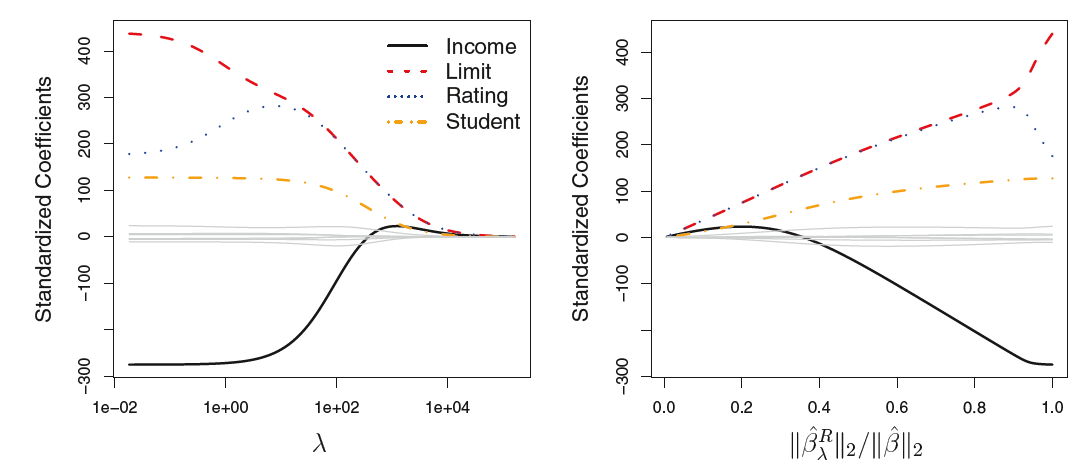

In [7]:
from IPython.display import Image
Image('images/pw46.png', width =700)

$\ell_2$ norm, $\left\Vert \beta \right\Vert_2 = \sqrt{\sum_{j=1}^p{\beta_j^2}}$

#### Example

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

+ We will use the `sklearn` package in order to perform ridge regression and the lasso. 
+ The main functions in this package that we care about are `Ridge()`, which can be used to fit ridge regression models, and `Lasso()` which will fit lasso models. 
+ They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before we proceed, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [11]:
df = pd.read_csv('data/hitters.csv').dropna().drop('Unnamed: 0', axis = 1)
df.info()
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [12]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    bool   
 17  Division_W   263 non-null    bool   
 18  NewLeague_N  263 non-null    bool   
dtypes: bool(3), f

+ The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model.
+ We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [13]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas


array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

+ Associated with each alpha value is a vector of ridge regression coefficients, which we'll store in a matrix `coefs`. 
+ In this case, it is a $19 \times 100$ matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of alpha). 
+ Remember that we'll want to standardize the variables so that they are on the same scale. To do this, we can use the `StandardScaler()` function:

In [14]:
ridge = Ridge()
coefs = []

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 19)

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. 

Let's plot and find out:

Text(0, 0.5, 'weights')

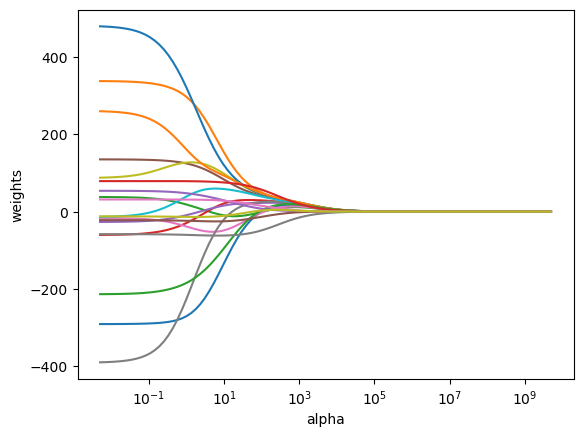

In [15]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression

In [16]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=1)

Fit a ridge regression model on the training set, and evaluate its MSE on the test set, using  $\lambda=4$ :

In [17]:
ridge2 = Ridge(alpha = 4)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE

AtBat         -213.176543
Hits           191.133532
HmRun          -54.236259
Runs             0.497409
RBI             77.755957
Walks           89.751563
Years          -27.347561
CAtBat        -120.436464
CHits           89.341261
CHmRun          83.888337
CRuns           98.317502
CRBI           116.286711
CWalks         -40.517948
PutOuts        117.412662
Assists         26.509603
Errors         -19.132449
League_N        36.016247
Division_W     -60.417909
NewLeague_N    -18.714889
dtype: float64
102375.70769613978


In [18]:
## Let alpha=10^10
ridge3 = Ridge(alpha = 10**10)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred3))          # Calculate the test MSE

AtBat          2.514813e-06
Hits           2.912660e-06
HmRun          1.986276e-06
Runs           2.685289e-06
RBI            3.189361e-06
Walks          3.118248e-06
Years          2.473459e-06
CAtBat         3.257461e-06
CHits          3.480687e-06
CHmRun         3.711503e-06
CRuns          3.474689e-06
CRBI           3.938490e-06
CWalks         3.029160e-06
PutOuts        3.055508e-06
Assists       -4.753637e-08
Errors         1.674891e-07
League_N      -1.638619e-07
Division_W    -1.015342e-06
NewLeague_N   -1.328587e-07
dtype: float64
172862.22014055075


+ This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept.
+ This over-shrinking makes the model more biased, resulting in a higher MSE.
+ now check whether there is any benefit to performing ridge regression with alpha = 4 instead of just performing least squares regression. 
+ Recall that least squares is simply ridge regression with alpha = 0.

In [19]:
### The least squares, alpha = 0
ridge2 = Ridge(alpha = 0)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE

AtBat          -267.752871
Hits            191.830073
HmRun           -41.721641
Runs             -0.988044
RBI             102.935440
Walks            75.220967
Years            45.444252
CAtBat        -1381.044044
CHits          1407.138021
CHmRun          244.425704
CRuns            88.048881
CRBI           -193.153012
CWalks           45.168467
PutOuts         117.645848
Assists          67.244233
Errors          -39.726067
League_N         66.762729
Division_W      -56.861659
NewLeague_N     -40.856844
dtype: float64
116690.46856663213


+ It looks like we are indeed improving over regular least-squares!

+ Instead of arbitrarily choosing alpha $ = 4$, it would be better to use cross-validation to choose the tuning parameter alpha. 
+ We can do this using the cross-validated ridge regression function, `RidgeCV()`. 
+ By default, the function performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the argument `cv`.

In [20]:
###  use cross-validation to choose the tuning parameter alpha. 
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

np.float64(87.37642000038414)

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 87.37. 

What is the test MSE associated with this value of
alpha?

In [21]:
###Fit to the test data
ridge4 = Ridge(alpha = ridgecv.alpha_)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))

100041.0014465957

This represents a further improvement over the test MSE that we got using
alpha $ = 4$. 

Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [22]:
###Fit to the whole data
ridge4.fit(X_scaled, y)

print(pd.Series(ridge4.coef_, index = X.columns))

AtBat          -3.523031
Hits           52.317273
HmRun          -2.229998
Runs           29.166801
RBI            22.313457
Walks          42.608761
Years          -5.214714
CAtBat         24.399636
CHits          46.574450
CHmRun         40.154375
CRuns          47.179284
CRBI           49.378118
CWalks          0.430680
PutOuts        58.565659
Assists         8.184012
Errors        -14.476788
League_N       15.731040
Division_W    -50.182047
NewLeague_N     2.213752
dtype: float64


### The Lasso
+ Least absolute shrinkage and selection operator
+ Ridge regression will include all $p$ predictors in the final model since it will only shrink the coefficients towards zero, not exactly zero. Therefore, if $p$ is large, then the model is hard to be interpreted.
+ Lasso can overcome this problem.
$$\sum_{i=1}^n{\left( y_i - \beta_0 - \sum_{j=1}^p{\beta_j x_{ij}} \right)^2} + \lambda \sum_{j=1}^p{\left|\beta_j\right|} = \textrm{RSS} + \lambda \sum_{j=1}^p{\left|\beta_j\right|}$$

+ Lasso uses $\ell_1$ penalty instead of $\ell_2$ (absolute value of predictors vs squared value). 
+ $\ell_1$ norm, $\left\Vert \beta \right\Vert_1 = \sum{\left| \beta_j \right|}$.
+ The lasso performs variable selection by setting some predictors to exactly 0 (and thus automatic variable selection), unlike ridge which will never completely do eliminate variables. 
+ The lasso yields sparse models — models that involve only a subset of the variables.



Lasso regression 

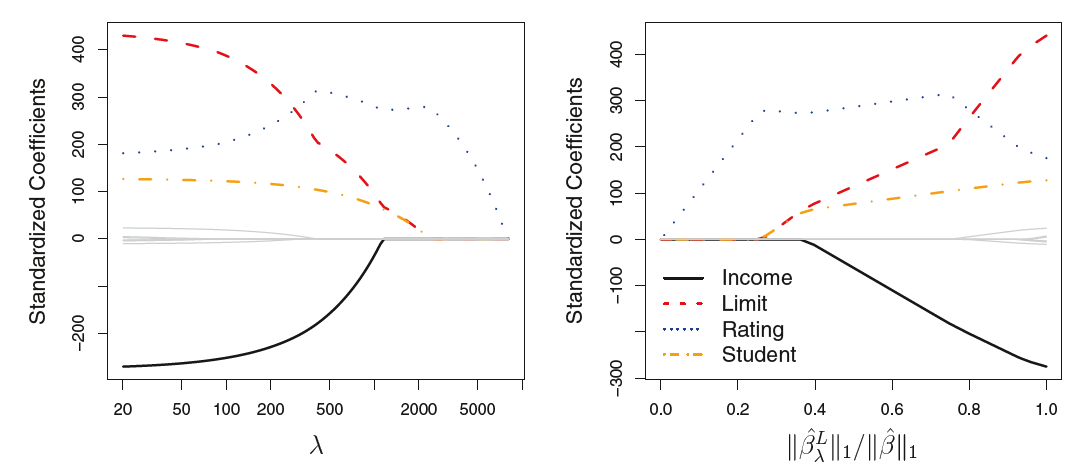

In [8]:
Image('images/pw47.png', width =700)

#### Example: 
+ we saw that ridge regression with a wise choice of alpha can outperform least squares as well as the null model on the Hitters data set. 
+ We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. 
+ In order to fit a lasso model, we'll use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
+ Other than that change, we proceed just as we did in fitting a ridge model:

Text(0, 0.5, 'weights')

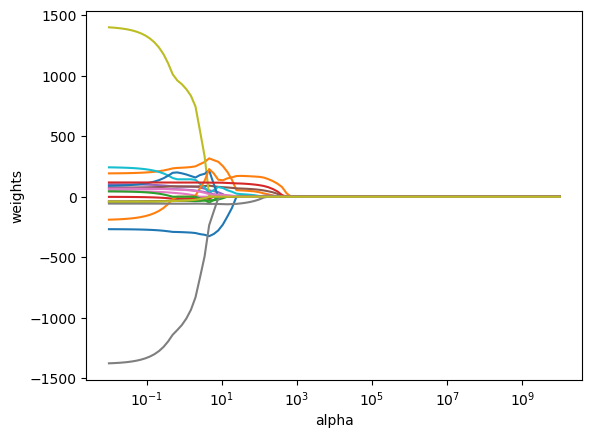

In [23]:
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

+ Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. 
+ We now perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [31]:
## Perform 10-fold cross-validation to choose the best alpha.

lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))

105121.06327904538

In [34]:
lassocv.alpha_

np.float64(28.038544563299848)

In [35]:
mean_squared_error(y_test, lassocv.predict(X_test))

105121.06327904538

This is substantially lower than the test set MSE of the null model and of least squares, and only a little worse than the test MSE of ridge regression with alpha chosen by cross-validation.

However, lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [38]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat            0.000000
Hits            47.417582
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks           64.015661
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun          16.243847
CRuns            0.000000
CRBI           168.983385
CWalks           0.000000
PutOuts        104.196395
Assists         -0.000000
Errors          -0.000000
League_N         0.000000
Division_W     -43.965512
NewLeague_N      0.000000
dtype: float64

### Alternative logic of lasso and ridge regression
+ Instead of thinking of penalizing the error by either the $\ell_1$ or $\ell_2$ norm, we can think of setting up lasso/ridge regression as minimizing the squared errors subject to keeping the parameters less than a certain value. 
+ Think of this value as a 'budget', $s$, of allowable spending to occur. You can allow yourself to spend your parameters in any way you chose as long as you don't go over the total budget.
+ For Lasso
$$\displaystyle \min_{\beta}\left\{ \sum_{i=1}^n{\left( y_i - \beta_0 - \sum_{j=1}^p{\beta_j x_{ij}} \right)^2} \right\} \quad \textrm{subject to} \quad \sum_{j=1}^p{\left|\beta_j\right|} \leq s$$
and for ridge regression
$$\displaystyle \min_{\beta}\left\{ \sum_{i=1}^n{\left( y_i - \beta_0 - \sum_{j=1}^p{\beta_j x_{ij}} \right)^2} \right\} \quad \textrm{subject to} \quad \sum_{j=1}^p{\beta^2_j} \leq s$$

+ Lasso yields predictors equivalent to 0 because of sharp corners


![ridge and lasso](images/ridge.png)

### Which is better Lasso or Ridge
+ In general, when there are many important predictor variables that related to the response, ridge will perform better. 
+ When there are only a few variables that relate to the response, lasso will do better.
+ However, cross validation can be used to determine this.

### Choosing $\lambda$
Choose $\lambda$ through cross validation. Search an array of $\lambda$'s through cross validation and choose the $\lambda$ which minimizes MSE. Then build your model with that $\lambda$ on all the data.

# Your turn!

1. Now it's time to test out these approaches (ridge regression and the lasso) and evaluation methods (validation set, cross validation) on other datasets. 
2. You may want to work with a team on this portion of the lab.
3. You may use any of the datasets from the UCI machine learning repository (http://archive.ics.uci.edu/ml/datasets.html). 
4. Download a dataset, and try to determine the optimal set of parameters to use to model it! You are free to use the same dataset you have used previously.